In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# generar 10 parcelas por variedad
variedades = {
    "Agria": {"mes_siembra": 2, "ciclo_semanas": 18},
    "Monalisa": {"mes_siembra": 1, "ciclo_semanas": 16},
    "Spunta": {"mes_siembra": 12, "ciclo_semanas": 15}
}

parcelas = {}
for variedad, vinfo in variedades.items():
    for i in range(1, 11):
        parcela_id = f"{variedad}_p{i}"
        parcelas[parcela_id] = {
            "variedad": variedad,
            "tam_ha": np.random.uniform(2,4),
            "ciclo_semanas": vinfo["ciclo_semanas"],
            "mes_siembra": vinfo["mes_siembra"]
        }

# fechas semanales
fechas = pd.date_range("2020-07-01", "2025-07-01", freq="W")

data_semanal = []
data_cosechas = []

for parcela, info in parcelas.items():
    variedad = info["variedad"]
    tam_ha = info["tam_ha"]
    ciclo_semanas = info["ciclo_semanas"]
    mes_siembra = info["mes_siembra"]
    
    rendimiento_acumulado = 0
    semana_cultivo = 0
    
    for fecha in fechas:
        mes_actual = fecha.month
        semana_del_año = fecha.isocalendar().week
        
        # iniciar campaña anual
        if mes_actual == mes_siembra and semana_cultivo == 0:
            semana_cultivo = 1
            rendimiento_acumulado = 0
            
        if semana_cultivo > 0:
            # clima según época
            if mes_actual in [12,1,2]:
                temp_media = np.random.normal(13,2)
                lluvia = np.clip(np.random.normal(20,10), 0, 50)
                riego = np.clip(np.random.normal(300,50), 150,450)
            elif mes_actual in [3,4,5]:
                temp_media = np.random.normal(17,3)
                lluvia = np.clip(np.random.normal(15,8), 0,40)
                riego = np.clip(np.random.normal(400,70), 250,550)
            elif mes_actual in [6,7,8]:
                temp_media = np.random.normal(27,3)
                lluvia = np.clip(np.random.normal(5,3), 0,15)
                riego = np.clip(np.random.normal(600,80), 400,800)
            else:
                temp_media = np.random.normal(20,3)
                lluvia = np.clip(np.random.normal(15,10), 0,50)
                riego = np.clip(np.random.normal(400,70), 250,550)
            
            # fertilizante
            if semana_cultivo <= 4:
                fertilizante = np.clip(np.random.normal(10,2),5,15)
            else:
                fertilizante = np.clip(np.random.normal(5,1.5),2,8)
            
            # rendimiento
            rendimiento_acumulado += (
                0.3 * fertilizante +
                0.05 * riego/100 +
                np.clip(temp_media - 15, 0, 10)*0.4 -
                0.1 * (30 - lluvia)/30
            )
            
            data_semanal.append({
                "fecha": fecha,
                "mes": mes_actual,
                "semana_del_año": semana_del_año,
                "parcela": parcela,
                "variedad": variedad,
                "tam_parcela_ha": tam_ha,
                "temp_media": temp_media,
                "lluvia": lluvia,
                "fertilizante": fertilizante,
                "riego": riego,
                "semana_cultivo": semana_cultivo
            })
            
            semana_cultivo += 1
            
            if semana_cultivo > ciclo_semanas:
                # fijar mes de cosecha según variedad
                if variedad == "Agria":
                    mes_cosecha = 6  # junio
                elif variedad == "Monalisa":
                    mes_cosecha = 5  # mayo
                elif variedad == "Spunta":
                    mes_cosecha = 4  # abril
                else:
                    mes_cosecha = fecha.month  # fallback

                rendimiento_ciclo = 25 + rendimiento_acumulado + np.random.normal(0,2)
                
                data_cosechas.append({
                    "fecha_cosecha": fecha,
                    "parcela": parcela,
                    "variedad": variedad,
                    "tam_parcela_ha": tam_ha,
                    "rendimiento_ton_ha": np.round(rendimiento_ciclo,2),
                    "mes_cosecha": mes_cosecha
                })
                
                semana_cultivo = 0  # parar ciclo hasta siguiente año

# dataframes
df_semanal = pd.DataFrame(data_semanal)
df_cosechas = pd.DataFrame(data_cosechas)

# guardar
df_semanal.to_csv("datos_semanales.csv", index=False)
df_cosechas.to_csv("datos_cosechas.csv", index=False)

print("\nPrimeras filas SEMANAL:")
print(df_semanal.head(10))

print("\nPrimeras filas COSECHAS:")
print(df_cosechas.head(10))


import pandas as pd
import numpy as np

np.random.seed(42)

# cargar histórico
historico = pd.read_csv("datos_semanales.csv", parse_dates=["fecha"])

fecha_max = historico["fecha"].max()
fechas_futuras = pd.date_range(fecha_max + pd.Timedelta(days=1), periods=28, freq="D")

parcelas = historico["parcela"].unique()

futuro = []

for parcela in parcelas:
    variedad = historico[historico["parcela"]==parcela]["variedad"].iloc[-1]
    tam_parcela = historico[historico["parcela"]==parcela]["tam_parcela_ha"].iloc[-1]
    
    for fecha in fechas_futuras:
        mes = fecha.month
        
        # temperatura
        if mes in [12,1,2]:
            temp_max = np.random.normal(17,2)
            temp_min = np.random.normal(8,2)
        elif mes in [6,7,8]:
            temp_max = np.random.normal(32,3)
            temp_min = np.random.normal(20,2)
        else:
            temp_max = np.random.normal(24,3)
            temp_min = np.random.normal(12,2)
        temp_media = (temp_max + temp_min) / 2
        
        # lluvia
        lluvia = np.clip(np.random.normal(2,2), 0,20)
        prob_lluvia = np.clip(np.random.normal(30,10), 0,100)
        
        # humedad
        humedad_rel = np.clip(np.random.normal(65,10),30,100)
        
        # viento
        viento_vel = np.clip(np.random.normal(15,5),0,40)
        viento_dir = np.random.randint(0,360)
        
        # radiación solar
        radiacion = np.clip(np.random.normal(15,5),5,30)  # MJ/m2/día
        
        # presión
        presion = np.clip(np.random.normal(1013,5),1000,1030)
        
        # ET0
        et0 = np.clip(np.random.normal(4,1),2,8)
        
        # sugerencias riego/ferti
        if temp_media > 25:
            riego_sug = np.clip(np.random.normal(25,5),15,35)
            ferti_sug = np.clip(np.random.normal(0.5,0.1),0.3,0.7)
        else:
            riego_sug = np.clip(np.random.normal(15,4),5,25)
            ferti_sug = np.clip(np.random.normal(0.3,0.05),0.1,0.5)
        
        futuro.append({
            "fecha": fecha,
            "parcela": parcela,
            "variedad": variedad,
            "tam_parcela_ha": tam_parcela,
            "temp_max": temp_max,
            "temp_min": temp_min,
            "temp_media": temp_media,
            "lluvia": lluvia,
            "prob_lluvia_%": prob_lluvia,
            "humedad_relativa_%": humedad_rel,
            "viento_vel_kmh": viento_vel,
            "viento_dir_deg": viento_dir,
            "radiacion_MJ_m2": radiacion,
            "presion_hPa": presion,
            "et0_mm": et0,
            "riego_sugerido_mm": riego_sug,
            "fertilizante_sugerido_kg": ferti_sug
        })
        
df_futuro = pd.DataFrame(futuro)
df_futuro.to_csv("prediccion_meteo_4semanas_completa.csv", index=False)

print("✅ CSV `prediccion_meteo_4semanas_completa.csv` generado con variables meteorológicas extendidas día a día.")




Primeras filas SEMANAL:
       fecha  mes  semana_del_año   parcela variedad  tam_parcela_ha  \
0 2021-02-07    2               5  Agria_p1    Agria         2.74908   
1 2021-02-14    2               6  Agria_p1    Agria         2.74908   
2 2021-02-21    2               7  Agria_p1    Agria         2.74908   
3 2021-02-28    2               8  Agria_p1    Agria         2.74908   
4 2021-03-07    3               9  Agria_p1    Agria         2.74908   
5 2021-03-14    3              10  Agria_p1    Agria         2.74908   
6 2021-03-21    3              11  Agria_p1    Agria         2.74908   
7 2021-03-28    3              12  Agria_p1    Agria         2.74908   
8 2021-04-04    4              13  Agria_p1    Agria         2.74908   
9 2021-04-11    4              14  Agria_p1    Agria         2.74908   

   temp_media     lluvia  fertilizante       riego  semana_cultivo  
0   10.698013  23.756980      9.416613  269.968066               1  
1   11.796587  38.522782      7.884578  299.

Mejores parámetros Stacking:
{'stack__final_estimator__alpha': 10.0}
Mejor R2 validación cruzada: 0.923
RMSE holdout: 2.51
R2 holdout: 0.93


  File "c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


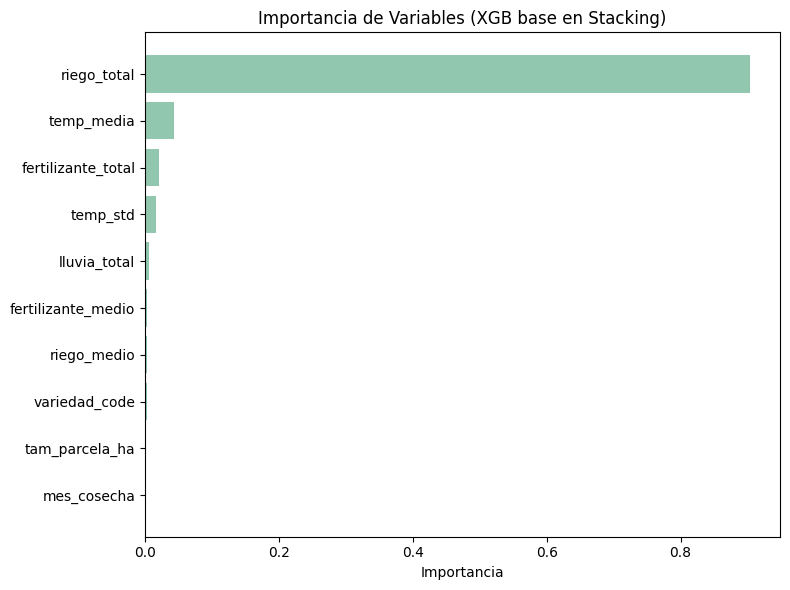

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1. Cargar datos
# ------------------------------------------------------------
semanal = pd.read_csv("datos_semanales.csv", parse_dates=["fecha"])
cosechas = pd.read_csv("datos_cosechas.csv", parse_dates=["fecha_cosecha"])

# ------------------------------------------------------------
# 2. Ingeniería de variables ciclo a ciclo
# ------------------------------------------------------------
features_ciclos = []

for parcela in semanal['parcela'].unique():
    datos_parcela = semanal[semanal['parcela'] == parcela].copy()
    datos_parcela = datos_parcela.sort_values("fecha")
    
    ciclos = datos_parcela.groupby((datos_parcela['semana_cultivo'] == 1).cumsum())
    
    for i, grupo in ciclos:
        fecha_cosecha = grupo['fecha'].max()
        variedad = grupo['variedad'].iloc[0]
        tam_parcela_ha = grupo['tam_parcela_ha'].iloc[0]
        
        temp_media = grupo['temp_media'].mean()
        temp_std = grupo['temp_media'].std()
        lluvia_total = grupo['lluvia'].sum()
        fertilizante_total = grupo['fertilizante'].sum()
        fertilizante_medio = grupo['fertilizante'].mean()
        riego_total = grupo['riego'].sum()
        riego_medio = grupo['riego'].mean()
        
        match = cosechas[
            (cosechas['parcela'] == parcela) & 
            (cosechas['fecha_cosecha'] == fecha_cosecha)
        ]
        if not match.empty:
            rendimiento = match['rendimiento_ton_ha'].iloc[0]
            
            features_ciclos.append({
                "parcela": parcela,
                "variedad": variedad,
                "tam_parcela_ha": tam_parcela_ha,
                "temp_media": temp_media,
                "temp_std": temp_std,
                "lluvia_total": lluvia_total,
                "fertilizante_total": fertilizante_total,
                "fertilizante_medio": fertilizante_medio,
                "riego_total": riego_total,
                "riego_medio": riego_medio,
                "rendimiento_ton_ha": rendimiento,
                "mes_cosecha": fecha_cosecha.month
            })

df = pd.DataFrame(features_ciclos)
df['variedad_code'] = df['variedad'].astype('category').cat.codes

# ------------------------------------------------------------
# 3. Definir X e y
# ------------------------------------------------------------
X = df[
    [
        "variedad_code", 
        "tam_parcela_ha",
        "temp_media", 
        "temp_std",
        "lluvia_total", 
        "fertilizante_total",
        "fertilizante_medio",
        "riego_total", 
        "riego_medio", 
        "mes_cosecha"
    ]
]
y = df["rendimiento_ton_ha"]

# grupos para cross-validation (usando parcela)
groups = df["parcela"]

# ------------------------------------------------------------
# 4. Stacking Ensemble avanzado
# ------------------------------------------------------------
base_learners = [
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('lgb', lgb.LGBMRegressor(random_state=42))
]
meta_learner = Ridge()

stacked = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', stacked)
])

param_grid = {
    'stack__final_estimator__alpha': [0.1, 1.0, 10.0],
}

gkf = GroupKFold(n_splits=5)

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=gkf.split(X, y, groups=groups),
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# 5. Entrenamiento
# ------------------------------------------------------------
grid.fit(X, y)

print("Mejores parámetros Stacking:")
print(grid.best_params_)
print(f"Mejor R2 validación cruzada: {grid.best_score_:.3f}")

# ------------------------------------------------------------
# 6. Evaluación holdout
# ------------------------------------------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42
)
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE holdout: {rmse:.2f}")
print(f"R2 holdout: {r2:.2f}")

# ------------------------------------------------------------
# 7. Importancia de variables del XGB base
# ------------------------------------------------------------
# sacamos la importancia del primer learner (XGB)
booster = best_model.named_steps['stack'].estimators_[0]
importances = booster.feature_importances_
feat_names = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(feat_names[sorted_idx], importances[sorted_idx], color="#91c7ae")
plt.title("Importancia de Variables (XGB base en Stacking)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


In [3]:
import joblib

# exportar el stacking completo
joblib.dump(best_model, "modelo_stack.pkl")
print("✅ Modelo guardado en modelo_stack.pkl")


✅ Modelo guardado en modelo_stack.pkl


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# cargar semanal
df = pd.read_csv("datos_semanales.csv", parse_dates=["fecha"])
df_cosechas = pd.read_csv("datos_cosechas.csv", parse_dates=["fecha_cosecha"])

features = ["temp_media", "lluvia", "fertilizante", "riego"]

X_seq = []
y_seq = []

for parcela in df["parcela"].unique():
    datos_parcela = df[df["parcela"] == parcela].sort_values("fecha")
    ciclos = datos_parcela.groupby((datos_parcela['semana_cultivo'] == 1).cumsum())

    for _, grupo in ciclos:
        seq = grupo[features].values
        if len(seq) < 12:
            continue
        seq = seq[:12]
        
        # generar el target como rendimiento acumulado simulado por semana
        cosecha = df_cosechas[
            (df_cosechas["parcela"] == parcela) &
            (df_cosechas["fecha_cosecha"] == grupo["fecha"].max())
        ]
        if not cosecha.empty:
            total_rend = cosecha["rendimiento_ton_ha"].iloc[0]
            # distribuimos de forma lineal como ejemplo
            y_vector = np.linspace(total_rend/12, total_rend, 12)
            X_seq.append(seq)
            y_seq.append(y_vector)

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# normalizar
scaler = MinMaxScaler()
n_samples, n_steps, n_features = X_seq.shape
X_seq_reshape = X_seq.reshape(-1, n_features)
X_seq_norm = scaler.fit_transform(X_seq_reshape)
X_seq_norm = X_seq_norm.reshape(n_samples, n_steps, n_features)

# --------------------------------------------------
# modelo LSTM
# --------------------------------------------------
model = models.Sequential([
    layers.LSTM(64, input_shape=(12, len(features)), return_sequences=True),
    layers.TimeDistributed(layers.Dense(16, activation="relu")),
    layers.TimeDistributed(layers.Dense(1))
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    X_seq_norm, y_seq.reshape(n_samples, n_steps, 1),
    epochs=200,
    batch_size=16,
    validation_split=0.2
)

model.save("modelo_lstm.h5")
print("✅ LSTM secuencial guardado en modelo_lstm_semanal.h5")


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1783.0837 - mae: 37.0164 - val_loss: 1243.7415 - val_mae: 31.0898
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1792.3549 - mae: 37.0672 - val_loss: 1211.9886 - val_mae: 30.6860
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1755.6576 - mae: 36.6978 - val_loss: 1123.9917 - val_mae: 29.6123
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1586.4000 - mae: 34.9120 - val_loss: 996.0725 - val_mae: 27.8646
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1440.0817 - mae: 33.1525 - val_loss: 876.2455 - val_mae: 25.9779
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1303.5009 - mae: 31.3179 - val_loss: 760.9543 - val_mae: 23.9622
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1188.4730 - mae: 29.6410 - val_loss: 654.6231 - val_mae: 21.9052
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1014.8557 - mae: 27.0508 - val_loss: 557.4311 - val_mae: 19.8243
Epoch 9/200
8/8 ━━━

✅ LSTM secuencial guardado en modelo_lstm_semanal.h5
